<a href="https://colab.research.google.com/github/Jeet1309/WiDS/blob/main/week2/Copy_of_dcgan_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

In [ ]:
# To generate GIFs
!pip install imageio
# !pip install git+https://github.com/tensorflow/docs!

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

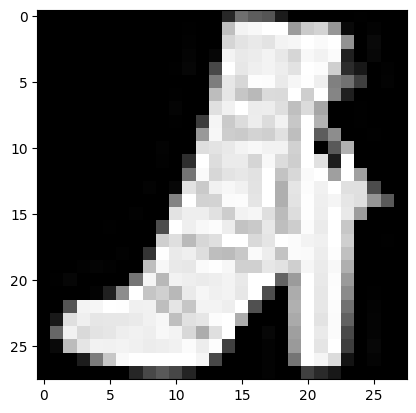

In [ ]:
plt.imshow(train_images[11, :, :, 0], cmap='gray')

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [ ]:
def make_generator_model2():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 28, 28, 16)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

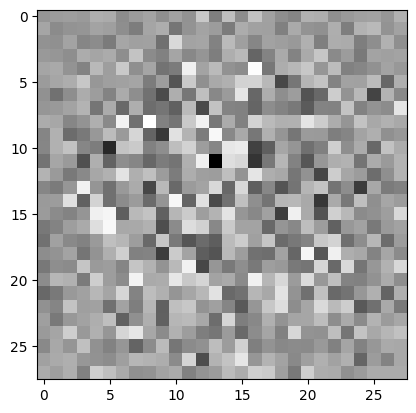

In [ ]:
generator = make_generator_model2()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
def make_discriminator_model2():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))


    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model2()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[8.4126405e-05]], shape=(1, 1), dtype=float32)


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.RMSprop(1e-5)
discriminator_optimizer = tf.keras.optimizers.RMSprop(1e-5)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
EPOCHS = 300
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):

    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)
      gen_loss_list = []
      disc_loss_list = []
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
      gen_loss_list.append(gen_loss)
      disc_loss_list.append(disc_loss)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss_list, disc_loss_list

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

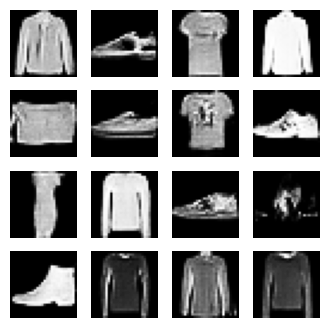

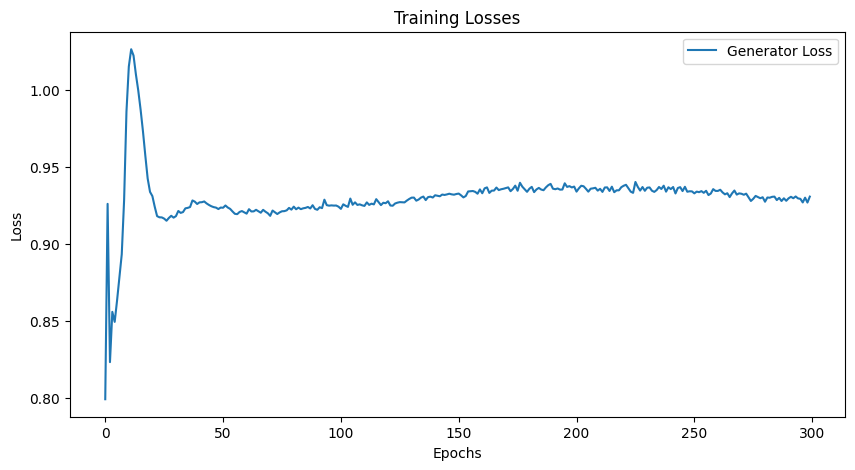

In [ ]:
def train(dataset, epochs):
    gen_loss_history = []  # Accumulate generator losses
    disc_loss_history = []  # Accumulate discriminator losses

    for epoch in range(epochs):
        start = time.time()

        epoch_gen_loss = []  # Losses for the current epoch
        epoch_disc_loss = []

        for image_batch in dataset:
            gen_loss_list, disc_loss_list = train_step(image_batch)

            # Extend the epoch losses with the batch losses
            epoch_gen_loss.extend(gen_loss_list)
            epoch_disc_loss.extend(disc_loss_list)

        # Append the mean loss for the epoch
        gen_loss_history.append(tf.reduce_mean(epoch_gen_loss).numpy())
        disc_loss_history.append(tf.reduce_mean(epoch_disc_loss).numpy())

        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

    return gen_loss_history, disc_loss_history

# Train and collect losses
gen_loss_history, disc_loss_history = train(train_dataset, EPOCHS)

# Plot the losses
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(gen_loss_history, label='Generator Loss')
# plt.plot(disc_loss_history, label='Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.show()


In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

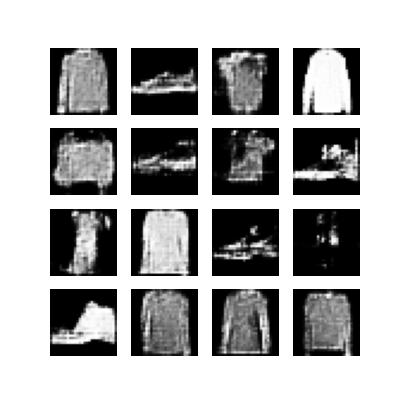

In [ ]:
display_image(42)

second better gan

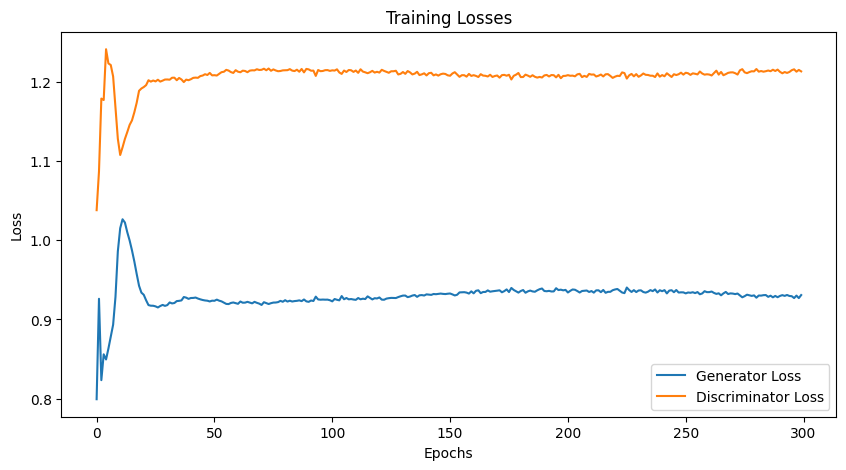

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(gen_loss_history, label='Generator Loss')
plt.plot(disc_loss_history, label='Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.show()


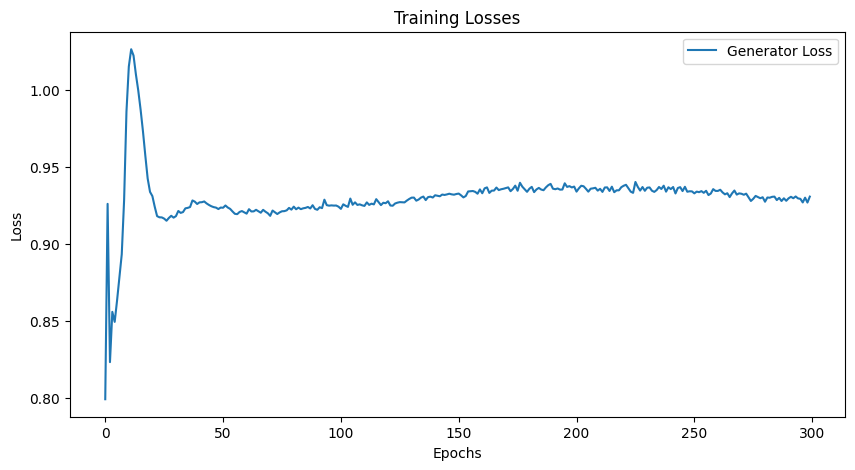

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(gen_loss_history, label='Generator Loss')
# plt.plot(disc_loss_history, label='Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.show()


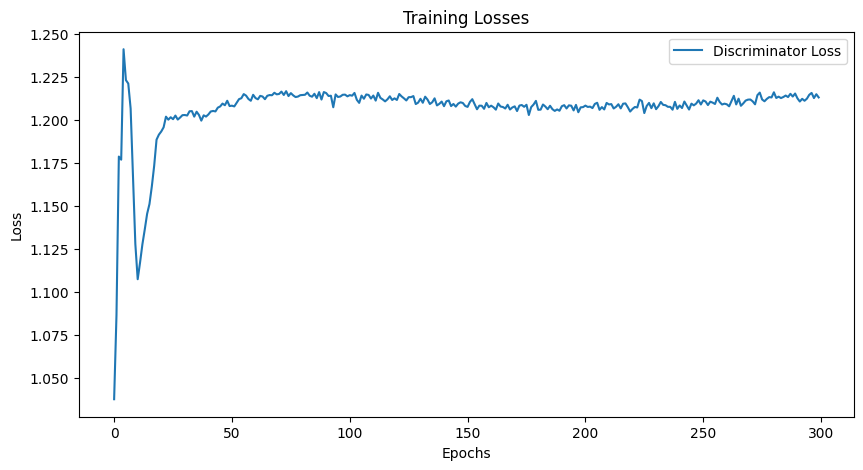

In [ ]:
plt.figure(figsize=(10, 5))
# plt.plot(gen_loss_history, label='Generator Loss')
plt.plot(disc_loss_history, label='Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.show()


In [ ]:
gen_loss_history[5:]

[0.86330837,
 0.8786876,
 0.8934252,
 0.9285412,
 0.9859598,
 1.015174,
 1.0264287,
 1.0223148,
 1.0101684,
 0.99972105,
 0.9872521,
 0.9731919,
 0.9574397,
 0.94256103,
 0.93389696,
 0.9311495,
 0.924235,
 0.91817915,
 0.91740274,
 0.9173404,
 0.91655314,
 0.91518676,
 0.9169899,
 0.9183952,
 0.9171857,
 0.91817117,
 0.92151636,
 0.92026967,
 0.92080116,
 0.9232127,
 0.92352825,
 0.92407614,
 0.92834526,
 0.9275624,
 0.92603934,
 0.9271071,
 0.9272074,
 0.92768055,
 0.92641824,
 0.9254294,
 0.9245941,
 0.9240111,
 0.92369103,
 0.92276824,
 0.9237399,
 0.9236032,
 0.9250763,
 0.9237562,
 0.9228738,
 0.9212103,
 0.91967857,
 0.91945,
 0.92088187,
 0.9214559,
 0.9206231,
 0.919786,
 0.9226856,
 0.9211836,
 0.9212706,
 0.92226803,
 0.92128843,
 0.9203796,
 0.9222513,
 0.92103064,
 0.92003274,
 0.9183551,
 0.9218022,
 0.9206743,
 0.91953635,
 0.9205802,
 0.9213271,
 0.9214129,
 0.9219219,
 0.92350316,
 0.922384,
 0.92432916,
 0.922622,
 0.9236975,
 0.9226908,
 0.92324203,
 0.9235319,
 0.92

In [ ]:
disc_loss_history[5:]

[1.2230525,
 1.2210609,
 1.2066014,
 1.1673499,
 1.1279732,
 1.1075335,
 1.1172218,
 1.1277977,
 1.1364101,
 1.1454645,
 1.1511767,
 1.1613917,
 1.1734155,
 1.1885171,
 1.1914169,
 1.1932448,
 1.1956595,
 1.2018428,
 1.2001019,
 1.2015144,
 1.2003834,
 1.2024821,
 1.2001487,
 1.2013539,
 1.2027216,
 1.2028023,
 1.2025096,
 1.2049694,
 1.2050834,
 1.2018653,
 1.2047148,
 1.2028435,
 1.1995434,
 1.2026187,
 1.2018967,
 1.2031283,
 1.2048489,
 1.2051579,
 1.204893,
 1.2070798,
 1.2077663,
 1.2094418,
 1.2084775,
 1.211074,
 1.2080023,
 1.2082187,
 1.2077895,
 1.209928,
 1.2120076,
 1.2125559,
 1.2149357,
 1.2140508,
 1.2121044,
 1.2110548,
 1.2145313,
 1.2126311,
 1.2119179,
 1.2139076,
 1.213535,
 1.2119709,
 1.2139579,
 1.2143868,
 1.214265,
 1.2157114,
 1.214801,
 1.2150105,
 1.2163869,
 1.2144316,
 1.2166315,
 1.2137942,
 1.2155042,
 1.2141854,
 1.2132255,
 1.2135029,
 1.2143011,
 1.2143996,
 1.2145516,
 1.2158575,
 1.2139825,
 1.2134281,
 1.2151307,
 1.21259,
 1.2160922,
 1.2117833,


In [ ]:
0.................................